In [1]:
import sys
sys.path.append('/code')

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML
from diffusion_utilities import *
from model import ContextUnet

In [3]:
# diffusion hyperparameters
timesteps = 500
beta1 = 1e-4
beta2 = 0.02

# network hyperparameters
device = torch.device("cuda:0" if torch.cuda.is_available() else torch.device('cpu'))
n_feat = 64 # 64 hidden dimension feature
n_cfeat = 5 # context vector is of size 5
height = 16 # 16x16 image
save_dir = 'code/weights'

# training hyperparameters
batch_size = 100
n_epoch = 32
lrate=1e-3

In [4]:
# construct DDPM noise schedule
b_t = (beta2 - beta1) * torch.linspace(0, 1, timesteps + 1, device=device) + beta1
a_t = 1 - b_t
ab_t = torch.cumsum(a_t.log(), dim=0).exp()    
ab_t[0] = 1

nn_model = ContextUnet(in_channels=3, n_feat=n_feat, n_cfeat=n_cfeat, height=height).to(device)

# load in pretrain model weights and set to eval mode
nn_model.load_state_dict(torch.load(f"{save_dir}/context_model_trained.pth", map_location=device))
nn_model.eval() 
print("Loaded in Context Model")

code/weights/context_model_trained.pth
Loaded in Context Model


In [5]:
def denoise_add_noise(x, t, pred_noise, z=None):
    if z is None:
        z = torch.randn_like(x)
    noise = b_t.sqrt()[t] * z
    mean = (x - pred_noise * ((1 - a_t[t]) / (1 - ab_t[t]).sqrt())) / a_t[t].sqrt()
    return mean + noise

In [6]:
@torch.no_grad()
def sample_ddpm_context(n_sample, context, save_rate=20):
    # x_T ~ N(0, 1), sample initial noise
    samples = torch.randn(n_sample, 3, height, height).to(device)  

    # array to keep track of generated steps for plotting
    intermediate = [] 
    for i in range(timesteps, 0, -1):
        print(f'sampling timestep {i:3d}', end='\r')

        # reshape time tensor
        t = torch.tensor([i / timesteps])[:, None, None, None].to(device)

        # sample some random noise to inject back in. For i = 1, don't add back in noise
        z = torch.randn_like(samples) if i > 1 else 0

        eps = nn_model(samples, t, c=context)    # predict noise e_(x_t,t, ctx)
        samples = denoise_add_noise(samples, i, eps, z)
        if i % save_rate==0 or i==timesteps or i<8:
            intermediate.append(samples.detach().cpu().numpy())

    intermediate = np.stack(intermediate)
    return samples, intermediate

In [7]:
plt.clf()
ctx = F.one_hot(torch.randint(0, 5, (32,)), 5).to(device=device).float()
samples, intermediate = sample_ddpm_context(32, ctx)
animation_ddpm_context = plot_sample(intermediate,32,4,save_dir, "ani_run", None, save=False)
HTML(animation_ddpm_context.to_jshtml())

<Figure size 640x480 with 0 Axes>

In [8]:
def show_images(imgs, nrow=2):
    _, axs = plt.subplots(nrow, imgs.shape[0] // nrow, figsize=(4,2 ))
    axs = axs.flatten()
    for img, ax in zip(imgs, axs):
        img = (img.permute(1, 2, 0).clip(-1, 1).detach().cpu().numpy() + 1) / 2
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(img)
    plt.show()

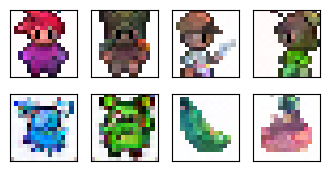

In [9]:
# user defined context
ctx = torch.tensor([
    # hero, non-hero, food, spell, side-facing
    [1,0,0,0,0],  
    [1,0,0,0,0],    
    [0,0,0,0,1],
    [0,0,0,0,1],    
    [0,1,0,0,0],
    [0,1,0,0,0],
    [0,0,1,0,0],
    [0,0,1,0,0],
]).float().to(device)
samples, _ = sample_ddpm_context(ctx.shape[0], ctx)
show_images(samples)

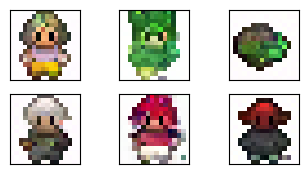

In [11]:
# mix of defined context
ctx = torch.tensor([
    # hero, non-hero, food, spell, side-facing
    [1,0,0,0,0],      #human
    [1,0,0.6,0,0],    
    [0,0,0.6,0.4,0],  
    [1,0,0,0,1],  
    [1,1,0,0,0],
    [1,0,0,1,0]
]).float().to(device)
samples, _ = sample_ddpm_context(ctx.shape[0], ctx)
show_images(samples)